In [31]:
from duckduckgo_search import ddg_images
from fastcore.all import L
from fastdownload import download_url
# from fastai.vision.all import *
from fastai.vision.all import download_images, resize_images, Image, Path
from fastai.vision.all import get_image_files, verify_images, PILImage
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize
from fastai.vision.all import vision_learner, resnet18, error_rate

## 1. Download images of birds and non-birds

In [2]:
def search_images(term, max_images=200): 
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('bird', 1)

/Users/quankento/miniconda3/envs/torch/lib/python3.9/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


In [4]:
urls[0]

'http://www.goats4h.com/birds/uploaded_images/BestBlue-750540.jpg'

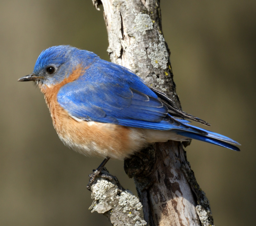

In [5]:
dest = 'bird1.jpg'
download_url(urls[0], dest)
im = Image.open(dest)
im.to_thumb(256, 256)

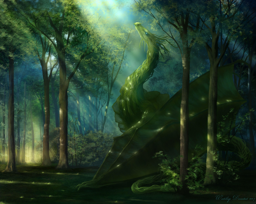

In [6]:
download_url(search_images('forest dragon', 1)[0], 'forest1.jpg')
Image.open('forest1.jpg').to_thumb(256, 256)

In [7]:
searches = 'forest', 'bird'
path = Path('bird_or_not1')
from time import sleep

for o in searches: 
    dest = path/o
    dest.mkdir(exist_ok=True, parents=True)
    
    download_images(dest, urls=search_images(f'{o} photo', 200))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun', 200))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade', 200))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## 2: Train our model

Some photos might not be downloaded correctly which could cause our model training to fail, so we'll remove them

In [10]:
failed = verify_images(get_image_files(path))
print('Numbef of failed imgs:', len(failed))
print('Failed images:', failed)

Numbef of failed imgs: 35
Failed images: [Path('bird_or_not1/forest/6b7ce4f0-d31f-4d56-baa3-7d5f8825725a.jpg'), Path('bird_or_not1/forest/22bb023c-5554-4cc8-b34e-2a80bc51d594.jpg'), Path('bird_or_not1/forest/85ce8865-f70d-437f-b82b-f36f5ae1bad8.jpg'), Path('bird_or_not1/forest/d4d59805-5e75-4582-bad0-a8646d2ee50a.jpg'), Path('bird_or_not1/forest/c9f1a12f-a19f-4358-8e04-f18465c15d1c.jpg'), Path('bird_or_not1/forest/f76860f6-b476-45a5-88ef-633bd0ca364a.jpg'), Path('bird_or_not1/forest/53daaef9-fe26-4cb3-803b-89e25a7322f0.jpg'), Path('bird_or_not1/forest/26efd3b1-ab97-4077-befa-34284a507059.jpg'), Path('bird_or_not1/forest/17bc7260-b9e8-41a8-bb3b-0662d04ac74c.jpg'), Path('bird_or_not1/bird/4d18cb58-cd49-45e8-99d1-dac693454064.jpg'), Path('bird_or_not1/bird/0f50e143-1ba2-4727-9b8b-f0cb5e33e7f1.jpg'), Path('bird_or_not1/bird/57034085-17b6-4297-8241-65fb711ba18b.jpg'), Path('bird_or_not1/bird/0e4e6823-f66b-4223-9fa8-bfc4cbc4b0ba.jpg'), Path('bird_or_not1/bird/e09e8d1d-045f-4257-be87-6d48bb7d

In [11]:
failed.map(Path.unlink)

(#35) [None,None,None,None,None,None,None,None,None,None...]

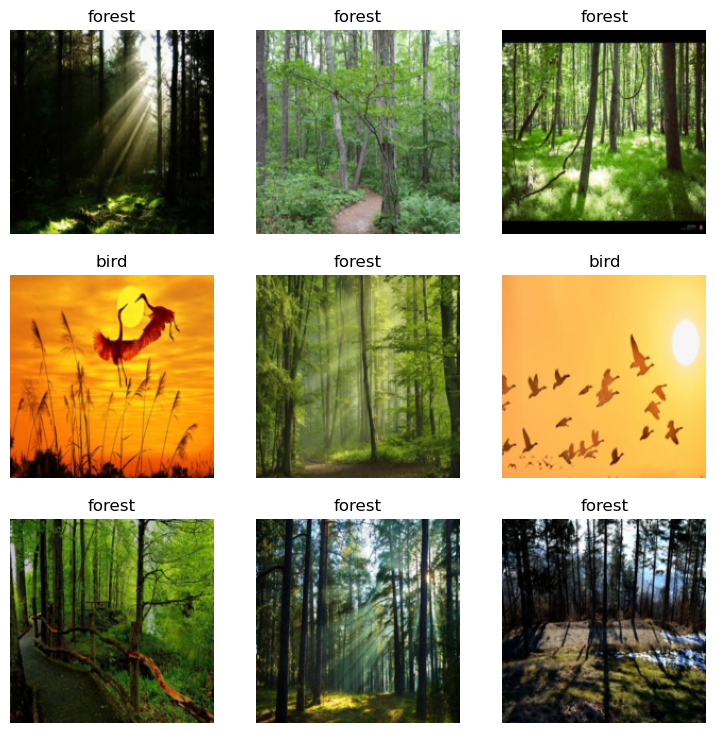

In [29]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(192, method='squish'),
).dataloaders(path)
dls.show_batch(max_n=9)

In [30]:
learn = vision_learner(dls, arch=resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.840789,0.425011,0.114583,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.130923,0.097167,0.020833,00:01
1,0.075783,0.059740,0.020833,00:01
2,0.049536,0.044622,0.020833,00:01


## 3. Use our model 

In [35]:
is_bird, _, probs = learn.predict(PILImage.create('./bird1.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs}")

This is a: bird.
Probability it's a bird: tensor([1.0000e+00, 6.7615e-08])


In [ ]:
print(learner.model.device)  # This will print 'cuda' if GPU is used, otherwise 'cpu'
print(dls.device)  #